In [15]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [16]:
data_path='data/COVID-19/time_series_covid19_confirmed_global.csv'
pd_raw=pd.read_csv(data_path)

time_idx=pd_raw.columns[4:]

df_plot = pd.DataFrame({
    'date':time_idx})

country_list=['India',
              'Germany',
              'Greece',
              'Italy'
             ] 

for each in country_list:
    df_plot[each]=np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0))

time_idx=[datetime.strptime( each,"%m/%d/%y") for each in df_plot.date] 
time_str=[each.strftime('%Y-%m-%d') for each in time_idx]

df_plot['date']=time_idx

df_plot.to_csv('data/processed/COVID_small_flat_table.csv',sep=';',index=False)



In [17]:
df_analyse=pd.read_csv('data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True)

,date,India,Germany,Greece,Italy
0,2020-01-22,0,0,0,0
1,2020-01-23,0,0,0,0
2,2020-01-24,0,0,0,0
3,2020-01-25,0,0,0,0
4,2020-01-26,0,0,0,0
...,...,...,...,...,...
912,2022-07-22,43868476,30331131,4210771,20539016
913,2022-07-23,43888755,30331133,4210771,20608190
914,2022-07-24,43905621,30331133,4210771,20660065
915,2022-07-25,43920451,30476605,4210771,20684182


In [18]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [19]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

start infected: 150
cumulative sum of invected after period 30598385
Number of days 877
N0 10000000
standard deviation errors :  [1.08120896e-04 5.66296647e-05]  start infect: 150
Optimal parameters: beta = 0.012714755143861015  and gamma =  -0.004736345889183793


/opt/homebrew/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/var/folders/dc/l2ls6f0542q6x629ltb1pc200000gn/T/ipykernel_23849/649699423.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
/var/folders/dc/l2ls6f0542q6x629ltb1pc200000gn/T/ipykernel_23849/649699423.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
/var/folders/dc/l2ls6f0542q6x629ltb1pc200000gn/T/ipykernel_23849/649699423.py:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I


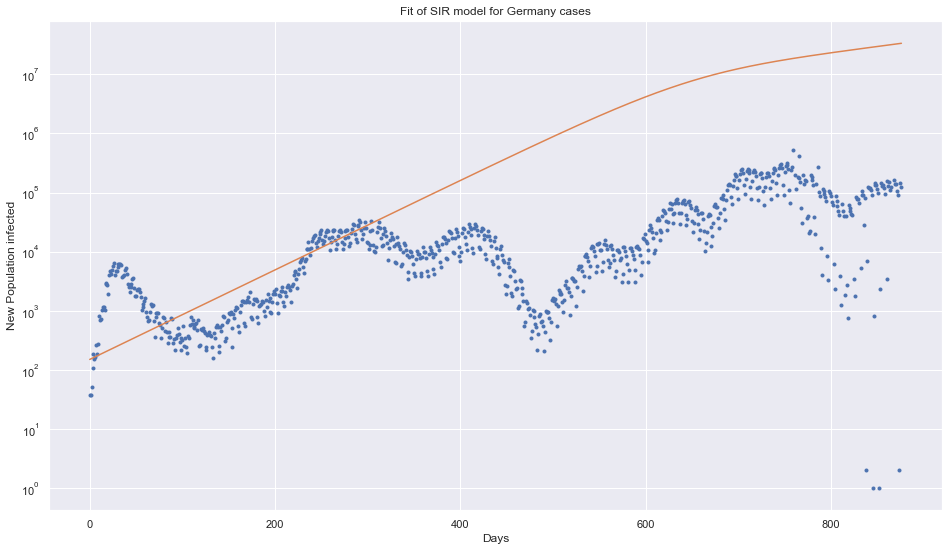

Optimal parameters: beta = 0.012714755143861015  and gamma =  -0.004736345889183793
Basic Reproduction Number R0  -2.684507306127536
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [20]:
ydata = np.array(df_analyse.Germany[40::])
t=np.arange(len(ydata))

N0=10000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
        
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), '.')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")
    



In [23]:
import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

import os
print(os.getcwd())


data_path='data/COVID-19/time_series_covid19_confirmed_global.csv'
data_pop = 'data/COVID-19/population.csv'

pd_raw = pd.read_csv(data_path)
pd_pop = pd.read_csv(data_pop)
country_list = pd_raw['Country/Region'].unique()
date=pd_raw.columns[4:]
df_analyse=pd.DataFrame({'Date':date})

for each in country_list:
    df_analyse[each] = np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0)).T
df_analyse.to_csv('data/COVID-19/SIR.csv',index=False)

df_analyse.sort_values('Date',ascending=True).head()
a=list(pd_pop['Pop'])

# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population as shown in the lecture taken random
beta=0.4   # infection spread dynamic
gamma=0.1  # recovery rate

df_data=df_analyse[35:]
t=np.arange(df_data.shape[0])
# condition I0+S0+R0=N0

R0=0

#for i in a:
    
#    N0=int(i)
    
for country in df_data.columns[1:]:
    y_data=np.array(df_data[df_data[country]>0][country])
    t=np.arange(len(y_data))

    I0=y_data[0]
    S0=N0-I0
    popt=[0.4,0.1]
    fit_odeint(t, *popt)
    popt, pcov = optimize.curve_fit(fit_odeint, t, y_data, maxfev=50000)
    perr = np.sqrt(np.diag(pcov))
    fitted=fit_odeint(t, *popt)
    fitted_pad = np.concatenate((np.zeros(df_data.shape[0]-len(fitted)) ,fitted))
    df_data[country + '_fitted'] = fitted_pad

df_data = df_data.reset_index(drop=True)
df_data.to_csv('data/processed/SIR_fitted_curve.csv')

/Users/savanvekariya/Documents/EDS/Covid19-dashboard


/var/folders/dc/l2ls6f0542q6x629ltb1pc200000gn/T/ipykernel_23849/2754255460.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_analyse[each] = np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0)).T
/var/folders/dc/l2ls6f0542q6x629ltb1pc200000gn/T/ipykernel_23849/2754255460.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_analyse[each] = np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0)).T
/var/folders/dc/l2ls6f0542q6x629ltb1pc200000gn/T/ipykernel_23849/2754255460.py:23: Perfo

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.4878789231498D+02   r2 =  0.2875859992902D-09


/var/folders/dc/l2ls6f0542q6x629ltb1pc200000gn/T/ipykernel_23849/2754255460.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
/opt/homebrew/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/var/folders/dc/l2ls6f0542q6x629ltb1pc200000gn/T/ipykernel_23849/649699423.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
/var/folders/dc/l2ls6f0542q6x629ltb1pc200000gn/T/ipykernel_23849/649699423.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/

In [25]:
import random
color_list = []
for i in range(200):
    var = '#%02x%02x%02x'%(random.randint(0,255),random.randint(0,255),random.randint(0,255))
    color_list.append(var)

In [26]:
fig = go.Figure()
app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Data Science SIR Modelling
    
    * This dashboard plots two curves for each country:
    
    The first curve represents the confirmed infected cases along the timeline.
    The second curve represents the simulated infected cases after applying the SIR model along the timeline. 
    
    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization from the dropdown
    '''),
    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in df_data.columns[1:200]],
        value=['India','France', 'China'], # which are pre-selected
        multi=True),
    dcc.Graph(figure=fig, id='main_window_slope')])


@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_figure(country_list):
    v = 0
    my_yaxis={'type':"log",'title':'Infected people'}
    traces = []
    for each in country_list:
        traces.append(dict(x=df_data['Date'],y=df_data[each],
                                mode='line', line = dict(color = color_list[v]), opacity=1.0,name=each))
        traces.append(dict(x=df_data['Date'],
                                y=df_data[each+'_fitted'],
                                mode='lines+markers',line = dict(color=color_list[v]), opacity=1.0,name=each+'_simulated'))

        v = v+1
    return {
            'data': traces,
            'layout': dict (
                width=1280,height=720,
                xaxis={'title':'Timeline','tickangle':-45,'nticks':20,
                'tickfont':dict(size=14,color="#0c6887"),},yaxis=my_yaxis)}

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
